# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
from pandas import concat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

import datetime
import time
from math import sqrt
from IPython.display import Image
from glob import glob

Using TensorFlow backend.


# Global Variables

In [2]:
directoriesList = ["C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171203/"]
filesDelimiter  = '\t'
window_size     = 5

pothole_output   = 1
speedbump_output = 2
default_output   = 0

# Functions 

In [3]:
def getFilesFromDirectories(directories, filetype = "csv", pattern = "*."):
    files     = []
    _pattern   = pattern + filetype
    
    try:
        for directory in directories:
            for dir,_,_ in os.walk(directory):
                files.extend(glob(os.path.join(dir, _pattern)))
    except:
        print("\Error to get files from directories. Do you do \"import os\" and \"from glob import glob\" ?")
        
    return files


def windowNormalization (serie, window_size):
    elems     = np.zeros(len(serie))
    pos_begin = pos_end = 0
    media     = std = 0.0
    count     = 0
    
    while count <= (len(elems) - window_size):
        
        #Is the process at the end?
        if (count + window_size == len(elems)):
            aux = count - 1
            while count < len(elems):
                elems[count] = elems[aux]
                count +=1
            break
            
        pos_end = pos_begin + window_size
        media   = np.mean(serie[pos_begin:pos_end])
        std     = np.std (serie[pos_begin:pos_end])
        
        elems[pos_begin] += np.sqrt((serie[pos_end] - media)**2/std)

        count     +=1
        pos_begin +=1
    
    return elems.tolist()
    
    
def fullNormalization(serie):
    media = np.mean(serie)
    std   = np.std(serie)
    
    return np.sqrt((serie - media)**2/std)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def strOp2datetime(_datetimestr = "", _format = "", _milliseconds = 0, _seconds = 0, _minutes = 0, _hours = 0):
    
    #first case: Just sum values with current datetime
    if _datetimestr is "" and _format is "":
        current_date = datetime.datetime.strptime(datetime.datetime.today().strftime('%Y %m %d %H %M %S %f'), "%Y %m %d %H %M %S %f")
        current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
        return str(current_date)
    
    #second case: sum values with given datetime
    if _datetimestr is not "" and _format is not "":
        try:
            current_date = datetime.datetime.strptime(_datetimestr, _format)
            current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
            return str(current_date)
        except:
            print('Are you sure you give the right format?')
            return None
        
    print('This method have two possible cases.\nFirst: _datetimestr and _format not filled.\nSecond:_datetimestr and _format filled\n')
    return None

def insertRepeatedValuesOnDataframe(dataframe, column_name, index_list, value, seconds = 1, both_side = True, forward = True):
    
    list_timestamp = []
    for dt in dataframe['datetime']:
        list_timestamp.append(int(time.mktime(time.strptime(dt,'%Y-%m-%d %H:%M:%S.%f'))))
    
    df_general['timestamp_datetime'] = list_timestamp

    for idx in index_list:
        #_date       = list((dataframe.loc[[idx]])['datetime'].values)[0]
        
        if both_side:
            begin_date = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] - seconds
            end_date   = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] + seconds
        else:
            if forward:
                begin_date = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] - 0
                end_date   = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] + seconds
            else:
                begin_date = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] - seconds
                end_date   = list((dataframe.loc[[idx]])['timestamp_datetime'].values)[0] + 0
                
        dataframe.loc[(dataframe['timestamp_datetime'] <= end_date) & (df_general['timestamp_datetime'] >= begin_date), column_name] = value
            
    return dataframe


def plotTooltipBokeh(axisSensor, dataframe, dataframe_pothole,dataframe_speedBump, _color = 'red', pos_df_pothole = 15, pos_df_speedBump = 18):
    from bokeh.models   import HoverTool, BoxZoomTool,UndoTool, SaveTool
    from bokeh.charts   import Line
    from bokeh.plotting import output_notebook, show
    from bokeh.models   import  BasicTickFormatter

    output_notebook()
    
    data      = {axisSensor: dataframe[axisSensor].tolist()}
    index     = dataframe['timestamp'].tolist()
    dataframe = pd.DataFrame(data=data, index=index)
    dataframe = dataframe.assign(x=dataframe.index)
    columns   = dataframe.columns.values.tolist()
    columns.remove('x')

    dataframe_pothole['Pothole occurrence']     = pos_df_pothole
    dataframe_speedBump['SpeedBump occurrence'] = pos_df_speedBump

    hover = HoverTool(
            tooltips=[
                ("lineNumberFile", "$index"),
                ("Timestamp, accelerometer", "($x{int}, $y)")
            ]
        )

    # Sensor's Data
    p = Line(data = dataframe, x ='x', legend = False,
             title="AXIS " + axisSensor[-1] + " - ACCELEROMETER",
             xlabel='Timestamp', ylabel='m/s^2',
             width=950, height=400, color=_color,
             notebook=True, tools = [hover,BoxZoomTool(),UndoTool(),SaveTool()])

    p.y_range.end   = 25
    p.x_range.start = dataframe['x'].iloc[0] - 10
    p.x_range.end   = dataframe['x'].iloc[-1]+ 1000

    # Pothole
    p.circle(dataframe_pothole['timestamp'].tolist(), dataframe_pothole['Pothole occurrence'].tolist(),fill_color="white",size=8)

    # SpeedBump
    p.inverted_triangle(dataframe_speedBump['timestamp'].tolist(), dataframe_speedBump['SpeedBump occurrence'].tolist(),size=8, color="#DE2D26")

    p.xaxis.formatter=BasicTickFormatter(use_scientific=False)
    show(p)

# Code

In [4]:
# Get Paths from specific file
speedbumpPath = getFilesFromDirectories(directoriesList, pattern = "SpeedBump_InicioAsfaltoVelhoAteRodovia*.")[0]
potholePath   = getFilesFromDirectories(directoriesList, pattern = "Pothole_InicioAsfaltoVelhoAteRodovia*.")[0]
generalPath   = getFilesFromDirectories(directoriesList, pattern = "InicioAsfaltoVelhoAteRodovia*.")[0]

In [5]:
# Reading csv files
df_general    = pd.read_csv(generalPath, delimiter   = filesDelimiter)
df_pothole    = pd.read_csv(potholePath, delimiter   = filesDelimiter)
df_speedbump  = pd.read_csv(speedbumpPath, delimiter = filesDelimiter)

In [6]:
# Build output column values
df_general.loc[df_general['timestamp'].isin(list(df_pothole['timestamp'])), 'output']   = pothole_output
df_general.loc[df_general['timestamp'].isin(list(df_speedbump['timestamp'])), 'output'] = speedbump_output

df_general['output'] = df_general['output'].fillna(default_output)

In [7]:
# Add the values from "timestamp" column in the current datetime and a new datetime column is created to be used as index
print ('Creating a new datetime column')
timestamp_values = list(df_general['timestamp'])

datetime_values = []
for value in timestamp_values:
    result = strOp2datetime(_milliseconds = int(value))
    if result is not None:
        datetime_values.append(result)

df_general['datetime'] = datetime_values
df_general.set_index('datetime')

print ('Created a new datetime column')

Creating a new datetime column
Created a new datetime column


In [8]:
# Adding event's values in a range of seconds in the dataframe
pothole_index_list   = list(df_general[df_general['output'] == 1].index)
speedbump_index_list = list(df_general[df_general['output'] == 2].index)

df_general = insertRepeatedValuesOnDataframe(df_general, 'output', pothole_index_list,   1, seconds = 1, both_side = True)
df_general = insertRepeatedValuesOnDataframe(df_general, 'output', speedbump_index_list, 2, seconds = 1, both_side = True)

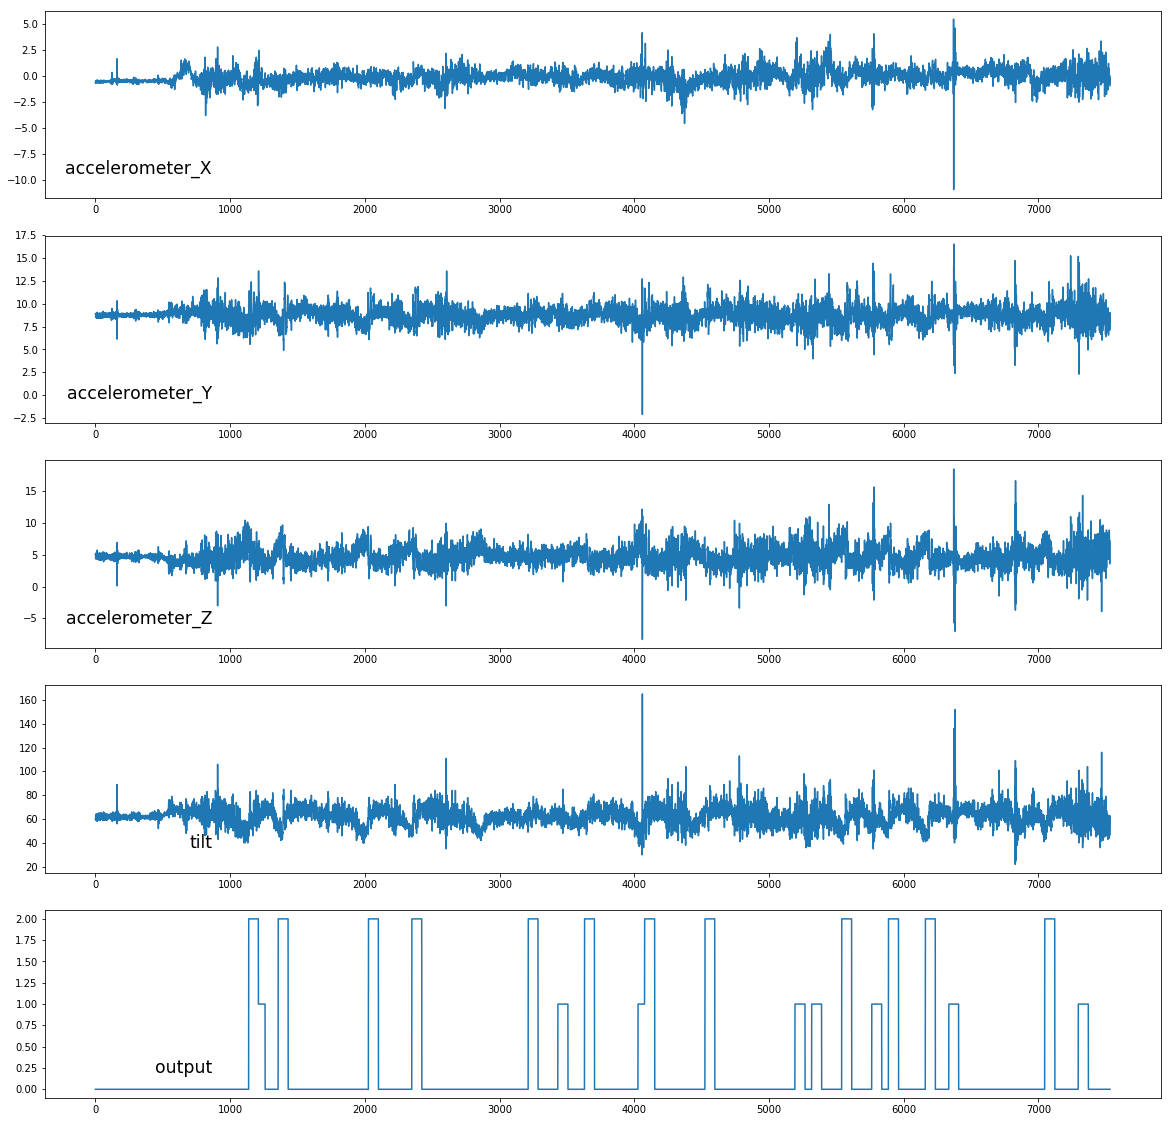

In [9]:
# Show the graphs of accelerometer values
values = df_general.values

# specify columns to plot
groups = [0, 1, 2, 5, 8]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_general.columns[group], x =0.15,y=0.1, size = 'xx-large', loc='right')
    i += 1
plt.show()

In [10]:
features = ['accelerometer_X','accelerometer_Y','accelerometer_Z','output']
values = df_general.filter(features, axis=1).values

# output column is removed to escape the normalization logic
no_output_values = values[:,:-1]

# ensure all data is float
no_output_values = no_output_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(no_output_values)

# inserts output column
scaled = np.insert(scaled, scaled.shape[1], values=values[:,-1], axis=1)

# specify the number of registers lag and n_features
# n_reg_lag = 60 means that i wanna process 60 values (2 seconds from past) from past to predict the current timestep
n_reg_lag  = 60
n_features = len(features)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_reg_lag, 1)

# drop columns we don't want to predict
reframed.drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1, inplace=True)

In [78]:
#values = reframed.values
#n_obs = n_features * n_reg_lag

#print(values[:,:n_obs-1])
#print('-'*60)
#print(values[0:, 0:(n_obs)])

In [11]:
# split into train and test sets
values = reframed.values

n_obs = n_features * n_reg_lag

# Split data into training and test
_train, _test, out_train, out_test = train_test_split(values[:,:n_obs], values[:,[n_obs]], test_size=0.4, random_state=42)

print(_train.shape,out_train.shape, _test.shape, out_test.shape)

(4483, 240) (4483, 1) (2989, 240) (2989, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
_train = _train.reshape((_train.shape[0] , n_reg_lag, n_features))
_test  = _test.reshape ((_test.shape[0]  , n_reg_lag, n_features))

print(_train.shape, out_train.shape, _test.shape, out_test.shape)

(4483, 60, 4) (4483, 1) (2989, 60, 4) (2989, 1)


In [13]:
idx = 0
train_out = []
for i in out_train:
    if (i[0] == 0):
        train_out.append([0,0,0])
    elif (i[0] == 1):
        train_out.append([0,1,0])
    else:
        train_out.append([0,0,1])
    idx +=1
    
out_train = np.asarray(train_out)

idx = 0
test_out = []
for i in out_test:
    if (i[0] == 0):
        test_out.append([0,0,0])
    elif (i[0] == 1):
        test_out.append([0,1,0])
    else:
        test_out.append([0,0,1])
    idx +=1
    
out_test = np.asarray(test_out)

In [14]:
# Remove target column from _train and _test
_train = _train[:, :, :-1]
_test  = _test[:, :, :-1]


In [15]:
# encode class values as integers
#Y = list(df_general['output'])

#encoder = LabelEncoder()
#encoder.fit(Y)
#encoded_Y = encoder.transform(Y)

# convert integers to dummy variables (i.e. one hot encoded)
#categorical_Y = np_utils.to_categorical(encoded_Y)

#[elem for elem in dummy_y if list(elem) == [0,0,1]] 

# Design Network

### TODO
- Remover target do _train e _test
- out_train e out_test transformar em categorical
- Adicionar eventos durante uma janela de tempo


In [37]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(_train.shape[1], _train.shape[2])))
model.add(Dense(3))
#model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize the model
print(model.summary())

#fit network
history = model.fit(_train, out_train, epochs=40, batch_size=400, validation_data=(_test, out_test), verbose=2, shuffle=False)

#plot history
#plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
#plt.legend()
#plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________
None
Train on 4483 samples, validate on 2989 samples
Epoch 1/40
 - 3s - loss: 1.9243 - val_loss: 1.8280
Epoch 2/40
 - 3s - loss: 1.9703 - val_loss: 1.8280
Epoch 3/40
 - 3s - loss: 1.9703 - val_loss: 1.8280
Epoch 4/40
 - 2s - loss: 1.9703 - val_loss: 1.8280
Epoch 5/40
 - 2s - loss: 1.9703 - val_loss: 1.8280
Epoch 6/40
 - 2s - loss: 1.9703 - val_loss: 1.8280
Epoch 7/40
 - 3s - loss: 1.9703 - val_loss: 1.8280
Epoch 8/40
 - 3s - loss: 1.9703 - val_loss: 1.8280
Epoch 9/40
 - 2s - loss: 1.9703 - val_loss: 1.8280
Epoch 10/40
 - 2s - lo


# Make a prediction

In [38]:
# make a prediction
yhat   = model.predict(_test)

# calculate RMSE
#rmse = sqrt(mean_squared_error(out_test, yhat))
#print('Test RMSE: %.3f' % rmse)

# More generic plots

In [14]:
plotTooltipBokeh('accelerometer_Y', df_general, df_pothole,df_speedbump,'red',20,22)

Loading BokehJS ...

C:\Program Files\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


[]

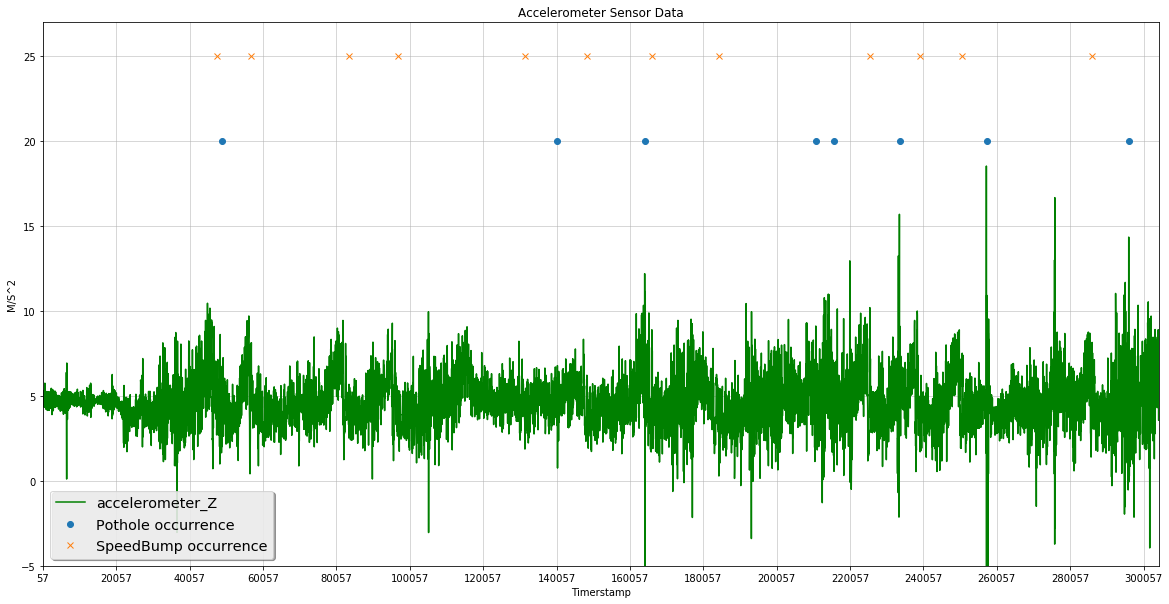

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_general['timestamp'],df_general['accelerometer_Z'], 'g-')

df_pothole['Pothole occurrence'] = 20
df_speedbump['SpeedBump occurrence'] = 25
ax.plot(df_pothole['timestamp'],df_pothole['Pothole occurrence'], 'o')
ax.plot(df_speedbump['timestamp'],df_speedbump['SpeedBump occurrence'], 'x')

#ax.legend(loc='lower left',bbox_to_anchor=(1.1, 0.5),fontsize='x-large')
ax.legend(loc='lower left',fontsize='x-large',shadow = bool)
ax.set_ylabel('M/S^2')
ax.set_xlabel('Timerstamp')
ax.set_title('Accelerometer Sensor Data')
ax.grid(True,linewidth=0.5,linestyle='-')
ax.set_xticks(np.arange(df_general['timestamp'].min(),df_general['timestamp'].max(), 20000))
ax.set_xlim([df_general['timestamp'].min(), df_general['timestamp'].max()])
ax.set_ylim([-5,27])
ax.plot()